# Introduction to programming artificial neural networks
#### Tutorial for Methods In Neuroscience at Dartmouth ([MIND](http://mindsummerschool.org/)) 2023
By [Mark A. Thornton](http://markallenthornton.com/)

This tutorial offers an introduction to programming your own customized artificial neural network (ANN) for the first time. It is based on the popular ANN programming framework [PyTorch](https://pytorch.org/). You will build up an ANN to perform regression, starting from a very simple network and working up step-by-step to a more complex one.

This notebook focuses on the implementation of ANNs. If you're interested in a complementary conceptual introduction to ANNs, their potential uses in social neuroscience, and their limitations, please consider [my preprint](https://psyarxiv.com/fr4cb) with [Beau Sievers](http://beausievers.com/).

The figure below, created by [Lindsey Tepfer](https://pbs.dartmouth.edu/people/lindsey-j-tepfer) for the aforementioned preprint, illustrates the (A) general structure of ANNs, (B) the internal structure of individual units, which approximate generalized linear models, and (C) the training process using stochastic gradient descent via backpropagation. The terminology in this figure will reappear throughout the tutorial.

![](https://mysocialbrain.org/misc/data/ann_tutorial/Fig1_DS_hires_top.png)


## Setup
This section includes the import statements for the packages/functions we'll need here, detection of the available hardware for ANN fitting, and code to simulate the artificial data we'll be using.

### Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

### Detect and set hardware device
Depending on where you run your notebook, you may be able to take advantage of different hardware. If a cuda-enable graphics card is available, this will be preferred. Mac chipsets (MPS) and traditional processors (CPU) are the fallback options. On Colab, you may want to change your runtime type to take advantage of the GPU runtimes they offer.

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Simulate data

In [6]:
# set random seeds
torch.manual_seed(0) # pytorch's random seed
np.random.seed(0) # numpy's random seed

In [7]:
# linear relationship

# set sample sizes
ntrain = 100000 # training
ntest = 1000    # testing
nval = 10000    # validation

# the x-variable is drawn from a standard normal distribution
x_train = np.random.normal(0,1,ntrain)
x_test = np.random.normal(0,1,ntest)
x_val = np.random.normal(0,1,nval)

# this y-variable is a linear function of the x-variable
# a bit a Gaussian noise is added, as well as a constant slope and intercept
y_lin_train = x_train*1.5 + np.random.normal(0,.1,ntrain) + 1
y_lin_test = x_test*1.5 + np.random.normal(0,.1,ntest) + 1

In [8]:
# nonlinear relationship
# the second y-variable is a quadratic function of the x-variable
y_non_train = np.power(x_train,2) + np.random.normal(0,.1,ntrain)
y_non_test = np.power(x_test,2) + np.random.normal(0,.1,ntest)
y_non_val = np.power(x_val,2) + np.random.normal(0,.1,nval)

In [9]:
# reshape so as to avoid confusing pytorch with 1d data
x_train.shape = (ntrain, 1)
y_lin_train.shape = (ntrain, 1)
y_non_train.shape = (ntrain, 1)
x_test.shape = (ntest, 1)
y_lin_test.shape = (ntest, 1)
y_non_test.shape = (ntest, 1)
x_val.shape = (nval, 1)
y_non_val.shape = (nval, 1)

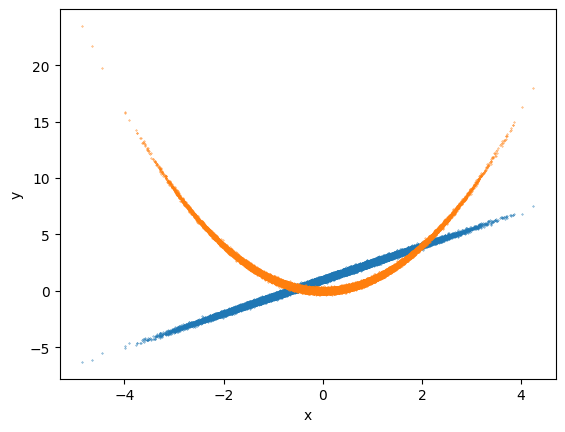

In [10]:
# plot simulated (training) data
plt.scatter(x_train,y_lin_train,s=.1)
plt.scatter(x_train,y_non_train,s=.1)
plt.xlabel("x");
plt.ylabel("y");

## Simple linear regression
We'll begin by showing how ANNs can approximate simple (OLS) regression. In fact, ANNs can approximate nearly all of the modeling techniques in the typical psych/neuro toolkit, ranging from this simple case up through things like factor analysis and beyond.

In [11]:
# define model with a single linear unit which takes one input
model1 = nn.Linear(1, 1)

In [12]:
# define loss (error) function as mean square error
# this is similar to ordinary least squares regression
loss = nn.MSELoss()

In [13]:
# define optimizers as stochastic gradient descent (SGD)
# feed in parameters of the model to be optimized and the learning rate
# (in most cases, we would probably use a much lower learning rate)
optimizer = torch.optim.SGD(model1.parameters(),lr=.5)

Now let's train the model:

In [14]:
nepoch = 10 # epochs = how many times the model sees the dataset
# note that we're not actually using the GPU yet - see the next example for that
for epoch in range(nepoch):
    # convert inputs and targets to torch tensors
    inputs = torch.from_numpy(np.float32(x_train))
    targets = torch.from_numpy(np.float32(y_lin_train))

    # propagate activity forward through network to make prediction
    outputs = model1(inputs)

    # compute loss (error) of predictions
    curloss = loss(outputs, targets)

    # backpropagate errors to change weights and biases via SGD
    optimizer.zero_grad()
    curloss.backward()
    optimizer.step()

    # print
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, nepoch, curloss.item()))


Epoch [1/10], Loss: 2.4881
Epoch [2/10], Loss: 0.0100
Epoch [3/10], Loss: 0.0100
Epoch [4/10], Loss: 0.0100
Epoch [5/10], Loss: 0.0100
Epoch [6/10], Loss: 0.0100
Epoch [7/10], Loss: 0.0100
Epoch [8/10], Loss: 0.0100
Epoch [9/10], Loss: 0.0100
Epoch [10/10], Loss: 0.0100


Now that we've trained the model, let's take a look at its out-of-sample performance on our simulated test set. To do this, we'll make predictions for the test set, and compare them to the actual test values using R<sup>2</sup> and RMSE, as well as plotting them against one another. As you'll see, the R<sup>2</sup> is near perfect, and the RMSE is just about equal to the SD of the noise we injected when simulating the data. In other words, the model is performing as well as it could.

0.9957496739688491
0.09758071680706164


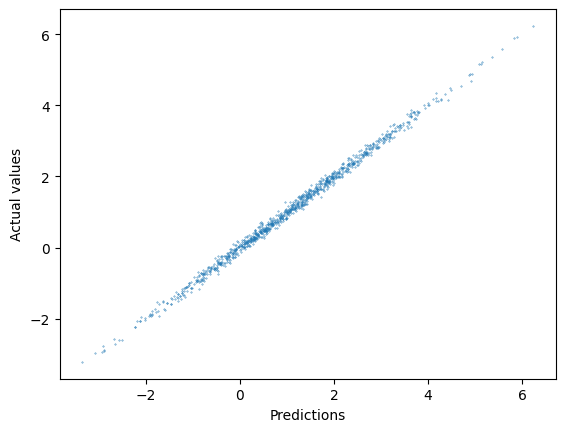

In [15]:
# plot the relationship between predicted and actual test values
ypred = model1(torch.from_numpy(np.float32(x_test))).detach().numpy()
plt.scatter(ypred,y_lin_test,s=.1)
plt.xlabel("Predictions");
plt.ylabel("Actual values");

# print out performance metrics
print(r2_score(y_lin_test,ypred))
print(np.sqrt(mean_squared_error(y_lin_test,ypred)))

Now let's compare the results to an ordinary least squares (OLS) regression - the more traditional way to model this sort of data in psychology and neuroscience. First, we'll print out the weight and bias of the sole unit in the neural network, and then fit and print the equivalent parameters (slope and intercept) of the OLS regression, using the statsmodels package.

In [16]:
# print out weight and bias parameters
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weight tensor([[1.5001]])
bias tensor([1.0004])


In [17]:
# observe that a traditional OLS regression learns the same parameter values
ols = sm.OLS(y_lin_train,sm.add_constant(x_train))
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.242e+07
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        04:59:40   Log-Likelihood:                 88450.
No. Observations:              100000   AIC:                        -1.769e+05
Df Residuals:                   99998   BIC:                        -1.769e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0004      0.000   3166.125      0.0

As you can see, despite the different implementation, an ANN can yield effectively identical results as familiar OLS regression, under idealized circumstances.

## Nonlinear regression
In the previous section, we saw how an ANN can be used to approximate a simple linear regression. However, one of the main advantages of ANNs is that they can model highly nonlinear relationships. In this section, we'll start to see how that can be achieved.

### Trying the linear model on nonlinear data
First, we will try to fit our simulated nonlinear (bivariate quadratic) data using the same model architecture we tried in this last section. This time we'll code up that model in a different way (i.e., a more object-oriented approach, instead of the more imperative approach above).

In [18]:
# define model architecture
class SimpleLinearANN(nn.Module):
    def __init__(self):
        super().__init__()
        # the "Sequential" class offers a convenient way to fit many simple ANNs
        self.layer_stack = nn.Sequential(
            nn.Linear(1,1)
        )

    def forward(self, x):
        pred = self.layer_stack(x)
        return pred

model2 = SimpleLinearANN().to(device)
print(model2)

SimpleLinearANN(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)


We'll also define our training and testing more functionally now, so that we can reuse these functions later.

In [19]:
# define training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # note that we're actually using the GPU here
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
# define test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, r2 = 0, 0 # evaluate loss (MSE, and R^2)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            r2 += 1 - torch.sum((y-pred)**2) / torch.sum(y **2)
    test_loss /= num_batches
    r2 /= num_batches
    print(f"Test performance: \n R^2: {r2:>8f}, RMSE: {np.sqrt(test_loss):>8f} \n")
    return r2.cpu().numpy(), test_loss

Next, we'll put our simulated data into pytorch's dataloader - an iterable class that supports batching (breaking up the overall dataset into smaller batches), and shuffling (randomizing the order of that data), among other features. Generally it's a good idea to choose a batch size that is a power of 2 (for memory efficiency), and to shuffle your data to prevent catastrophic forgetting that can come from showing the model a bunch of similar examples in a row.

In [21]:
# turn our numpy variables into pytorch datasets
xtrain_tensor = torch.from_numpy(np.float32(x_train))
ytrain_tensor = torch.from_numpy(np.float32(y_non_train))
nonlinear_training_data = TensorDataset(xtrain_tensor, ytrain_tensor)

xtest_tensor = torch.from_numpy(np.float32(x_test))
ytest_tensor = torch.from_numpy(np.float32(y_non_test))
nonlinear_testing_data = TensorDataset(xtest_tensor, ytest_tensor)

xval_tensor = torch.from_numpy(np.float32(x_val))
yval_tensor = torch.from_numpy(np.float32(y_non_val))
val_data = TensorDataset(xval_tensor, yval_tensor)

# put the datasets into the dataloader
train_dataloader = DataLoader(nonlinear_training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(nonlinear_testing_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [22]:
# new we'll train the model (note that loss does not seem steadily to improve)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(),lr=.5)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model2, loss, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 3.297604  [   64/100000]
loss: 2.270447  [ 6464/100000]
loss: 2.475495  [12864/100000]
loss: 2.216384  [19264/100000]
loss: 2.483925  [25664/100000]
loss: 3.111267  [32064/100000]
loss: 2.170219  [38464/100000]
loss: 3.388379  [44864/100000]
loss: 4.701067  [51264/100000]
loss: 1.805016  [57664/100000]
loss: 1.798295  [64064/100000]
loss: 2.880607  [70464/100000]
loss: 1.875021  [76864/100000]
loss: 1.566702  [83264/100000]
loss: 1.444066  [89664/100000]
loss: 3.873803  [96064/100000]
Epoch 2
-------------------------------
loss: 1.891131  [   64/100000]
loss: 1.695512  [ 6464/100000]
loss: 1.589921  [12864/100000]
loss: 1.268939  [19264/100000]
loss: 1.167627  [25664/100000]
loss: 1.327818  [32064/100000]
loss: 1.701994  [38464/100000]
loss: 0.960532  [44864/100000]
loss: 1.701208  [51264/100000]
loss: 5.352643  [57664/100000]
loss: 1.198715  [64064/100000]
loss: 2.584759  [70464/100000]
loss: 2.101575  [76864/100000]
loss: 2.096920  [8326

As we can see below, the performance of the linear model is poor, and it is not capturing the nonlinear relationship in the data.


In [23]:
# performance metrics
perf = test(test_dataloader, model2, loss)

Test performance: 
 R^2: 0.300736, RMSE: 1.491297 



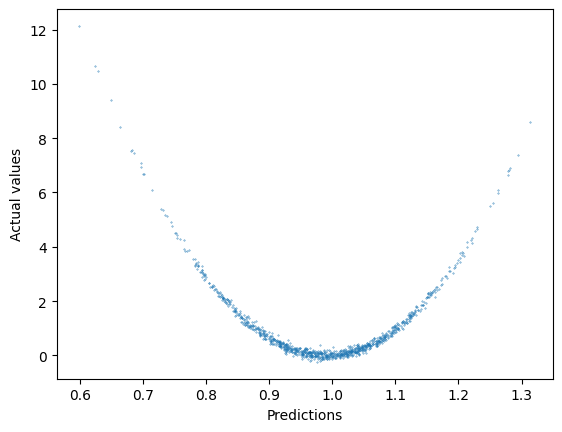

In [24]:
# plotting actual values vs. predictions
ypred = model2(torch.from_numpy(np.float32(x_test)).to(device)).cpu().detach().numpy()
plt.scatter(ypred,y_non_test,s=.1)
plt.xlabel("Predictions");
plt.ylabel("Actual values");

### Shallow/wide nonlinear ANN
As we've seen, linear regression can't capture a nonlinear relationship. The traditional approach to dealiung with this would be to do some manual feature engineering, like creating a quadratic term by multiplying our "x" by itself. This approach would actually work fine with the simulated data we're playing with here. However, it does not scale up well to datasets with more variables and more complex nonlinearities. A major part of the appeal of ANNs is that - under the right circumstances - they can learn optimal nonlinear mappings between inputs and outputs for us.

Most of the ANNs you'll see making news these days are "deep" neural networks. The deep in this phrase refers to stacking a large number of layers on top of each other. However, before we do that, it's worth taking a look at "shallow" neural networks. Shallow networks can actually do everything that deep nets can do - in principle. In practice, they tend to do this in a different way, that is [often less than ideal](https://ojs.aaai.org/index.php/AAAI/article/view/10913/10772). Specifically, shallow networks are memorization machines. They learn many simple local approximations to the relationship between inputs and outputs. With enough capacity, they can memorize an arbitrarily complex relationship, making them universal function approximators. Let's see how this works! Below we'll train a shallow ANN with many more units, and a nonlinear activation function ([ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) - probably the most popular nonlinear activation function for ANNs).

In [25]:
# define model architecture
class ShallowWideANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(1,1000),  ## layer with 1000 units!
            nn.ReLU(),      ## apply a nonlinear activation function
            nn.Linear(1000,1),      ## single linear output
        )

    def forward(self, x):
        pred = self.layer_stack(x)
        return pred

model3 = ShallowWideANN().to(device)
print(model3)

ShallowWideANN(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1, bias=True)
  )
)


In [26]:
# new we'll train the model
# note that we've tuned down the learning rate
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model3.parameters(),lr=.001)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model3, loss, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 2.869074  [   64/100000]
loss: 0.120316  [ 6464/100000]
loss: 0.041936  [12864/100000]
loss: 0.037916  [19264/100000]
loss: 0.028931  [25664/100000]
loss: 0.040988  [32064/100000]
loss: 0.178121  [38464/100000]
loss: 0.031798  [44864/100000]
loss: 0.067478  [51264/100000]
loss: 0.031456  [57664/100000]
loss: 0.021962  [64064/100000]
loss: 0.018875  [70464/100000]
loss: 0.023422  [76864/100000]
loss: 0.053598  [83264/100000]
loss: 0.023415  [89664/100000]
loss: 0.033236  [96064/100000]
Epoch 2
-------------------------------
loss: 0.016946  [   64/100000]
loss: 0.024055  [ 6464/100000]
loss: 0.046232  [12864/100000]
loss: 0.016391  [19264/100000]
loss: 0.019041  [25664/100000]
loss: 0.017909  [32064/100000]
loss: 0.016895  [38464/100000]
loss: 0.022496  [44864/100000]
loss: 0.050606  [51264/100000]
loss: 0.016962  [57664/100000]
loss: 0.020621  [64064/100000]
loss: 0.017214  [70464/100000]
loss: 0.021813  [76864/100000]
loss: 0.025850  [8326

In [27]:
# performance metrics
# the shallow network is doing quite well!
perf = test(test_dataloader, model3, loss)

Test performance: 
 R^2: 0.990787, RMSE: 0.171964 



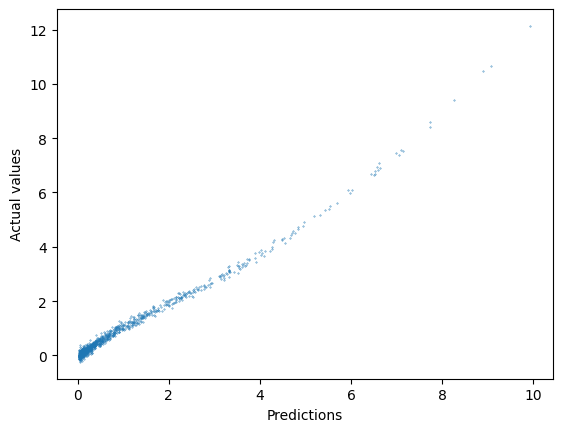

In [28]:
# plotting actual values vs. predictions
ypred = model3(torch.from_numpy(np.float32(x_test)).to(device)).cpu().detach().numpy()
plt.scatter(ypred,y_non_test,s=.1)
plt.xlabel("Predictions");
plt.ylabel("Actual values");

As you can see, the shallow network has learned a pretty good approximation of the nonlinear relationship in our data, just by memorizing small bits of it in each unit. The results here aren't perfect, but with infinite data and infinite units, a shallow network can get arbitrarily close to perfection. In our more mundane world of limited data and models, deep neural networks typically offer a better solution.

### Deep neural network
In the example below, we'll use far fewer units to achieve similar performance, via a deep neural network. This network features 5 ReLU layers, with units decreasing in power of two. The final layer is a single linear unit, as in previous cases. An important addition here is batch normalization after each ReLU activation. Batch normalization is basically like z-scoring the data. This is really helpful to prevent what's known as the "exploding gradient" problem. Basically, nonlinear transformations have the potential to make some numbers really huge (or tiny) and this can cause problems for numerical computing with float point representations. Batch normalization helps to mitigate this problem, serving as a sort of regularization that improves training.

In [29]:
# define model architecture
class DeepANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(1,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8,4),
            nn.ReLU(),
            nn.BatchNorm1d(4),
            nn.Linear(4,2),
            nn.ReLU(),
            nn.BatchNorm1d(2),
            nn.Linear(2,1)
        )

    def forward(self, x):
        pred = self.layer_stack(x)
        return pred

model4 = DeepANN().to(device)
print(model4)

DeepANN(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=4, out_features=2, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [30]:
# new we'll train the model
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model4.parameters(),lr=.01)
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model4, loss, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 4.667707  [   64/100000]
loss: 0.989088  [ 6464/100000]
loss: 0.216513  [12864/100000]
loss: 0.264145  [19264/100000]
loss: 0.306660  [25664/100000]
loss: 0.456342  [32064/100000]
loss: 0.057279  [38464/100000]
loss: 0.060745  [44864/100000]
loss: 0.394866  [51264/100000]
loss: 0.418425  [57664/100000]
loss: 0.314052  [64064/100000]
loss: 0.173316  [70464/100000]
loss: 0.039098  [76864/100000]
loss: 0.173622  [83264/100000]
loss: 0.153746  [89664/100000]
loss: 0.228229  [96064/100000]
Epoch 2
-------------------------------
loss: 0.071922  [   64/100000]
loss: 0.055156  [ 6464/100000]
loss: 0.248226  [12864/100000]
loss: 0.049417  [19264/100000]
loss: 0.040127  [25664/100000]
loss: 0.057625  [32064/100000]
loss: 0.714862  [38464/100000]
loss: 0.200428  [44864/100000]
loss: 0.236930  [51264/100000]
loss: 0.031537  [57664/100000]
loss: 0.179619  [64064/100000]
loss: 0.115763  [70464/100000]
loss: 0.201975  [76864/100000]
loss: 0.044374  [8326

In [31]:
# performance metrics
perf = test(test_dataloader, model4, loss)

Test performance: 
 R^2: 0.980514, RMSE: 0.292389 



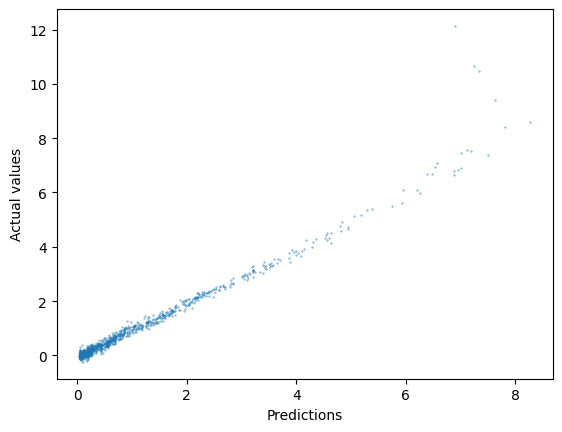

In [32]:
# plotting actual values vs. predictions
ypred = model4(torch.from_numpy(np.float32(x_test)).to(device)).cpu().detach().numpy()
plt.scatter(ypred,y_non_test,s=.1)
plt.xlabel("Predictions");
plt.ylabel("Actual values");

In [33]:
# compute the number of trainable parameters in shallow and deep net
m3p = sum(p.numel() for p in model3.parameters() if p.requires_grad)
m4p = sum(p.numel() for p in model4.parameters() if p.requires_grad)
print("Shallow net parameter number: " + str(m3p))
print("Deep net parameter number: " + str(m4p))

Shallow net parameter number: 3001
Deep net parameter number: 901


As you can see, the deep net has achieved similar performance to the shallow network, with only a fraction of the parameters!

### Bells and whistles
The deep net we used in the previous example was quite "bare bones" by contemporary standards. In practice, most deep nets rely on a variety of other features to improve their performance. Showcasing all of these features is beyond the scope of this tutorial, but the example below demonstrates a few popular examples, including:


*   <b>Skip-layer connections</b>: In the most prototypical case, each layer in an ANN is connected only to the adjacent layers (e.g., layer 2 is connected to layer 1 and layer 3). This is known as a sequential structure, and the sequential class in pytorch makes this very convenient. However, some of the most important milestones in deep learning have been achieved by abandoning this simple structure. For example, resnets (residual networks) are an  architecture that allowed computer vision to equal humans in tasks like object identification. These networks rely on connections that skip layers. The network below demonstrates this: in addition to receiving input from the previous layer, the final outputs here also receive input from the first layer. The potential of the nn.Module class extends well beyond this too: it can be used to stitch together different ANNs performing different tasks in different ways.
*   <b>Alternate activation functions</b>: Although ReLU is probably the most popular default choice of nonlinear activation function, there are many options to choose from, and some may be better suited to particular problems. Here we demonstrate the use of the hyperbolic tangent (tanh) function as an alternative to ReLU. For niche applications (e.g., cognitive modeling) you could even craft your own bespoke activation functions.
*   <b>Dropout</b>: ANNs can use the same regularization, like ridge/lasso, that typical linear models can use. However, dropout is a method unique to ANNs. This method effectively "lesions" a random subset of units during the forward pass of the model. This forces the model to acquire a more robust structure - effectively, many different assemblies that can accomplish the same end goal - that tends to reduce overfitting.
*   <b>Early stopping</b>: Another strategy to prevent overfitting is early stopping. This strategy only makes sense for optimization strategies that proceed in a sequential manner (like gradient descent) rather than a single step of matrix math. Early stopping compares the performance of the model in training set to its performance in a validation set. As long as validation performance continues to improve, the model keep training. But when training performance improves while validation performance stalls, this is a sign of overfitting. Early stopping tracks this potential divergence between training and validation, and stops training when validation performance stops improving.


In [34]:
# define model architecture
class FancyANN(nn.Module):
    def __init__(self, ninput=1, noutput=1, nhlayer=5, fextint=True):
        super().__init__()
        self.fextint = 0
        if fextint:
            self.fextint = 2**nhlayer
        self.nhlayer = nhlayer
        self.layerlist = nn.ModuleList()
        for i in range(nhlayer):
            if i == 0:
                self.layerlist.append(nn.Linear(ninput,2**(nhlayer-i)))
            else:
                self.layerlist.append(nn.Linear(2**(nhlayer-i+1),2**(nhlayer-i)))
            self.layerlist.append(nn.Tanh())    # here's our alternative activation function (tanh)
            self.layerlist.append(nn.BatchNorm1d(2**(nhlayer-i)))
            self.layerlist.append(nn.Dropout(p=.01))    ## here's where we add dropout
        self.layerlist.append(nn.Linear(self.fextint+2,noutput))

    def forward(self, x):
        for i in range(len(self.layerlist)-1):
            x = self.layerlist[i](x)
            if i == 2:
                x0 = torch.clone(x)
        pred = self.layerlist[-1](torch.cat((x0,x),1)) ## here's where the first layer and penultimate layer get joined together as inputs to the final layer
        return pred

model5 = FancyANN().to(device)
print(model5)

FancyANN(
  (layerlist): ModuleList(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): Tanh()
    (10): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=8, out_features=4, bias=True)
    (13): Tanh()
    (14): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.01, inplace=False)
    (16): Linear(in_features=4, out_features=2, bias=True)
    (17): Tanh()
    (18): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, trac

In [35]:
# this class defines the logic of early stopping
# higher patience means that improvement on the validation set has to stall for longer before training is terminated
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [36]:
# new we'll train the model
early_stopper = EarlyStopper(patience=3, min_delta=0)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model5.parameters(),lr=.0001) # we're trying a different optimizer here too (ADAM)
epochs = 100 # this is just an upperbound - the actual epoch # is determined by early stopping
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model5, loss, optimizer)
    val_loss = test(val_dataloader, model5, loss)[1]
    if early_stopper.early_stop(val_loss):
        break
print("Done!")

Epoch 1
-------------------------------
loss: 3.888131  [   64/100000]
loss: 3.917098  [ 6464/100000]
loss: 2.937878  [12864/100000]
loss: 5.071633  [19264/100000]
loss: 3.716036  [25664/100000]
loss: 2.398747  [32064/100000]
loss: 1.351015  [38464/100000]
loss: 1.365817  [44864/100000]
loss: 1.875855  [51264/100000]
loss: 1.061013  [57664/100000]
loss: 1.337905  [64064/100000]
loss: 1.853627  [70464/100000]
loss: 0.764148  [76864/100000]
loss: 0.915834  [83264/100000]
loss: 0.340542  [89664/100000]
loss: 0.346805  [96064/100000]
Test performance: 
 R^2: 0.780519, RMSE: 0.845240 

Epoch 2
-------------------------------
loss: 0.396910  [   64/100000]
loss: 0.205753  [ 6464/100000]
loss: 0.607033  [12864/100000]
loss: 1.113463  [19264/100000]
loss: 0.097006  [25664/100000]
loss: 0.100322  [32064/100000]
loss: 0.931996  [38464/100000]
loss: 0.178657  [44864/100000]
loss: 0.537315  [51264/100000]
loss: 0.205982  [57664/100000]
loss: 0.245556  [64064/100000]
loss: 0.080524  [70464/100000]


In [37]:
# performance metrics
perf = test(test_dataloader, model5, loss)

Test performance: 
 R^2: 0.992059, RMSE: 0.155234 



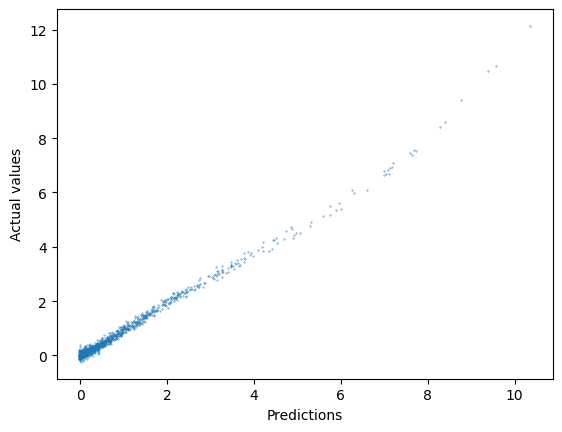

In [38]:
# plotting actual values vs. predictions
ypred = model5(torch.from_numpy(np.float32(x_test)).to(device)).cpu().detach().numpy()
plt.scatter(ypred,y_non_test,s=.1)
plt.xlabel("Predictions");
plt.ylabel("Actual values");

The bells and whistles buy us only a little bit of extra performance here, but this is a very simple case. In more complex, multivariate situations, these features can have a major effect on model performance.

## Next steps
This tutorial has provided a basic example of how one can create one's own artificial neural network using pytorch. However, there's a lot more that you can do with deep nets beyond what's been shown here. This final section will point you to some directions for further learning that you may be interested in.

### Other layer connectivity patterns
The layers in the networks you've seen here are all "densely" connected. This means that every unit in one layer is connected to every unit in another layer. Most of the connections are also sequential, with the exception of the skip layer connection in the last model. However, there are a wide variety of other connectivity patterns that can perform better for particular applications. Several of these patterns are illustrated in the figure below.

![](https://mysocialbrain.org/misc/data/ann_tutorial/Fig1_DS_hires_bottom.png)

* The bottleneck (red) in the autoencoder illustration is a layer that is narrower (i.e., has fewer units) than the ones before or after it. This forces this layer to learn a compressed representation of the data - a bit like PCA, but nonlinear, not (necessarily) orthogonal, and with potentially different loss functions than maximizing variance explained.

* Convolutional networks are ubiquitous due to their effectiveness in dealing with image-like data (e.g., photos, video, fMRI, or even spectrograms of audio or electrophysiology). The connectivity pattern - and receptive fields that emerge - loosely approximate the human visual system.

* Recurrent connectivity carries a unit's activity forward from one time point to another. Long short-term memory (LSTM) networks are probably the best known example of this type. These models are most often used for time series and other sequential data.

* Perhaps the most important type of unit/connectivity (not pictured due to its complexity) is the attention mechanism of transformer architectures. Transformers are beyond the scope of this introduction, but they support many of the most influential ANNs as of time of writing (e.g., all  the major large language models like GPT).

### Applications
One way to organize your learning is to think about how you want to apply deep nets in your own research. The figure below illustrates some of the main uses cases that you might be interested in. These include (A) training statistical biomarkers to predict phenotypes from brain data, (B) using computer vision/audition models to annotate behavior in stimuli/recordings of participants, and (C) training models on the same tasks as participants, so that they can be used as cognitive models. Once you know which of these applications you want to use in your research, it can help you figure out where to go next. ![](https://mysocialbrain.org/misc/data/ann_tutorial/Fig2_DS.png)


### Learning resources

Tutorial material:
* [Pytorch's official tutorials](https://pytorch.org/tutorials/)

* [Tensorflow's official tutorials](https://www.tensorflow.org/tutorials)

Websites:

* If you're looking to find the best (pre-trained) model for a specific application, [Paper's with Code](https://paperswithcode.com/) is in an extremely useful source. It tracks the state of the art with respect to a huge number of machine learning benchmarks, with links their papers and github repos.

* [Hugging Face](https://huggingface.co/) is a model repository where an increasing number of popular pretrained models are uploaded. It provides a consistent API for installing, using, and documenting models, most of which are programmed in PyTorch and/or Tensorflow.

* [DeepMind Blog](https://www.deepmind.com/blog): Google DeepMind maintains a blog where they write about their papers in (relatively) accessible ways.

Videos:

* Neuromatch's video playlists on [deep learning](https://www.youtube.com/watch?v=IZvcy0Myb3M&list=PLkBQOLLbi18PZ2uw0p7G4EkzjzqP8l0Eg), and [autoencoders](https://www.youtube.com/watch?v=VwSnDJZekQ4&list=PLkBQOLLbi18Ojl1CV8W00JZ0C0hivBxw1),  

* [NYU deep learning course](https://www.youtube.com/watch?v=0bMe_vCZo30&list=PLLHTzKZzVU9eaEyErdV26ikyolxOsz6mq).

* Berkeley [Deep Reinforcement Learning Bootcamp](https://sites.google.com/view/deep-rl-bootcamp/lectures)

* [Two minute papers](https://www.youtube.com/@TwoMinutePapers) Short, easily digested videos on recent modeling

Many of my favorite scientific papers on deep learning are cited within these two papers:

* Thornton, M.A., & Sievers, B. (2023). Deep social neuroscience: The promise and peril of using artificial neural networks to study the social brain. <i>PsyArXiv.</i> [Preprint](https://psyarxiv.com/fr4cb)

* Lin, C., Bulls, L. S., Tepfer, L. J., Vyas, A., Thornton, M. A., (2023).
Advancing naturalistic affective science with deep learning. <i>Affective Science.</i> [Preprint](https://psyarxiv.com/j5q9h/)

In [39]:
import keras
import tensorflow

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [41]:
import numpy as np
import matplotlib.pyplot as plt


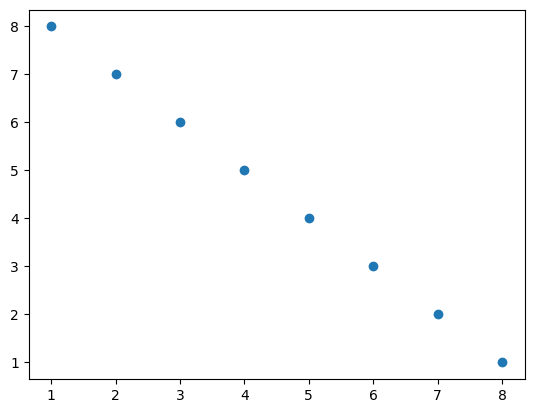

In [43]:
x=np.array([1,2,3,4,5,6,7,8])
y=np.array([8,7,6,5,4,3,2,1])
plt.scatter(x,y)
plt.show()

In [44]:
model=Sequential()
model.add(Dense(1,input_dim=1,activation='linear'))
model.add(Dense(1,activation='linear'))
model.compile(Adam(learning_rate=0.01),loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.fit(x,y,epochs=20,verbose=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 23.3223
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 22.7680
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 22.2505
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 21.7691
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 21.3228
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 20.9100
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 20.5278
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 20.1730
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 19.8422
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 19.5325
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 19.2421
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 18.9693
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 18.7131
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 18.4725
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 18.2465
Epoch 16/20
1/1 ━━━━━

In [46]:
model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[0.8104663],
       [1.5547386],
       [2.2990112],
       [3.043284 ],
       [3.7875566],
       [4.5318284],
       [5.276101 ],
       [6.0203733]], dtype=float32)

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [48]:
adv=pd.read_csv(r"/content/advertising.csv")
adv

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


from matplotlib import pyplot as plt
adv['TV'].plot(kind='hist', bins=20, title='TV')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv['Radio'].plot(kind='hist', bins=20, title='Radio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv['Newspaper'].plot(kind='hist', bins=20, title='Newspaper')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv.plot(kind='scatter', x='TV', y='Radio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv.plot(kind='scatter', x='Radio', y='Newspaper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv.plot(kind='scatter', x='Newspaper', y='Sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
adv['TV'].plot(kind='line', figsize=(8, 4), title='TV')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
adv['Radio'].plot(kind='line', figsize=(8, 4), title='Radio')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
adv['Newspaper'].plot(kind='line', figsize=(8, 4), title='Newspaper')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
adv['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

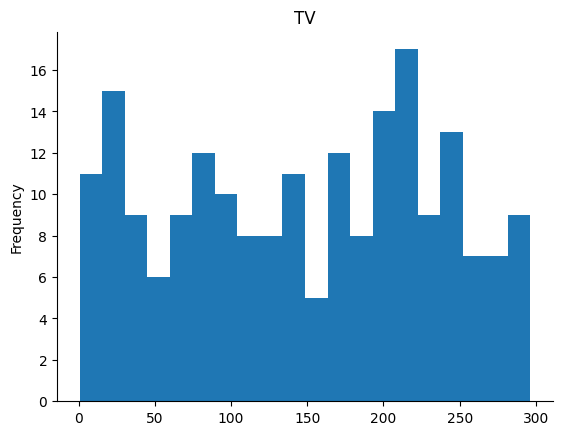

In [49]:
# @title TV

from matplotlib import pyplot as plt
adv['TV'].plot(kind='hist', bins=20, title='TV')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [50]:
adv.isnull().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


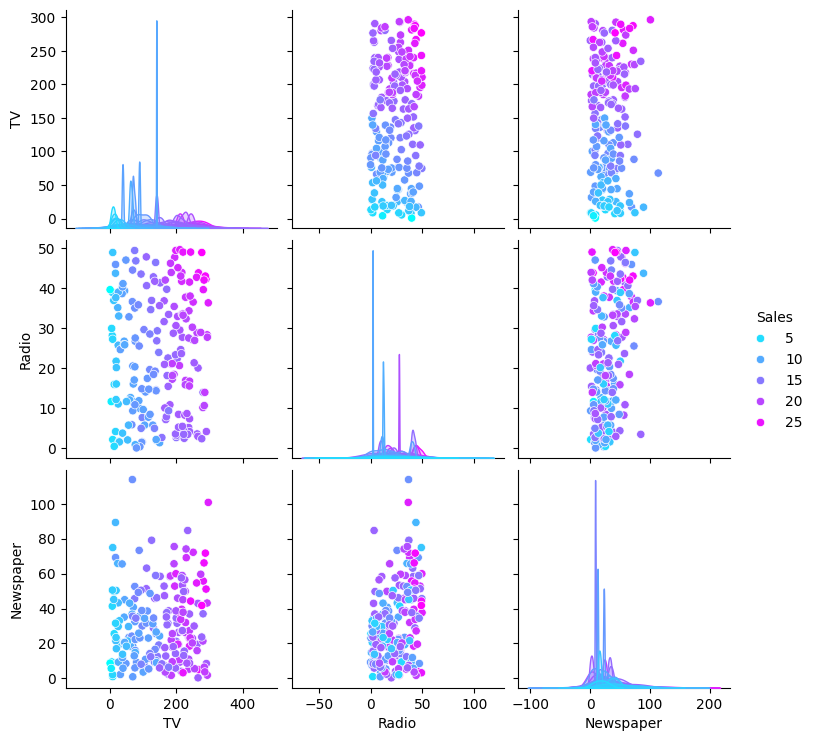

In [51]:
sns.pairplot(adv,hue='Sales',palette='cool')
plt.show()

In [53]:
ip=adv.drop('Sales',axis=1)
op=adv.Sales

In [55]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(ip,op,test_size=0.2)


In [57]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [58]:
model= Sequential()
model.add(Dense(30,input_dim=3,activation='linear'))

model.add(Dense(25,activation="linear"))
model.add(Dense(15,activation="linear"))

model.add(Dense(1,activation='linear'))
model.compile(Adam(learning_rate=0.01),loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
